<a href="https://colab.research.google.com/github/shuheng0330/Hackathon-2025/blob/main/Hackathon_Domain_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install cybotrade-datasource
!pip install hmmlearn

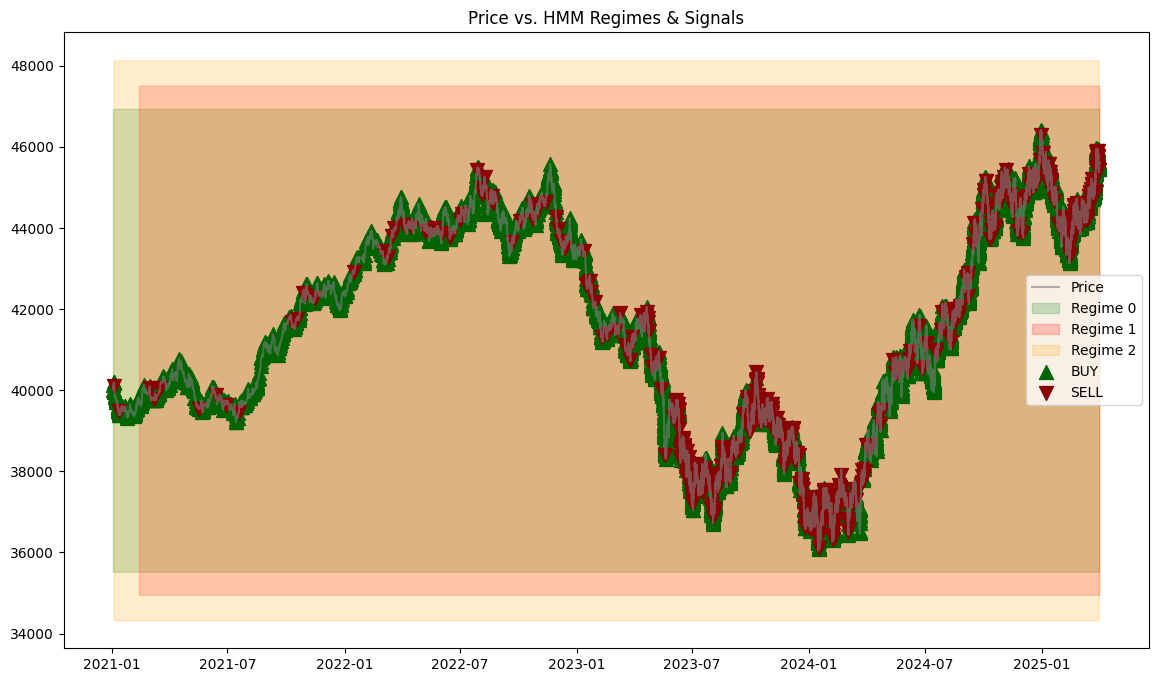


📈 Backtest Performance:
Final PnL: 5.73%
Sharpe Ratio: 2.02
Max Drawdown: -0.13%
Trade Frequency: 0.0379

📈 Forward Test Performance:
Final PnL: 14.71%
Sharpe Ratio: 1.82
Max Drawdown: -0.29%
Trade Frequency: 0.0276


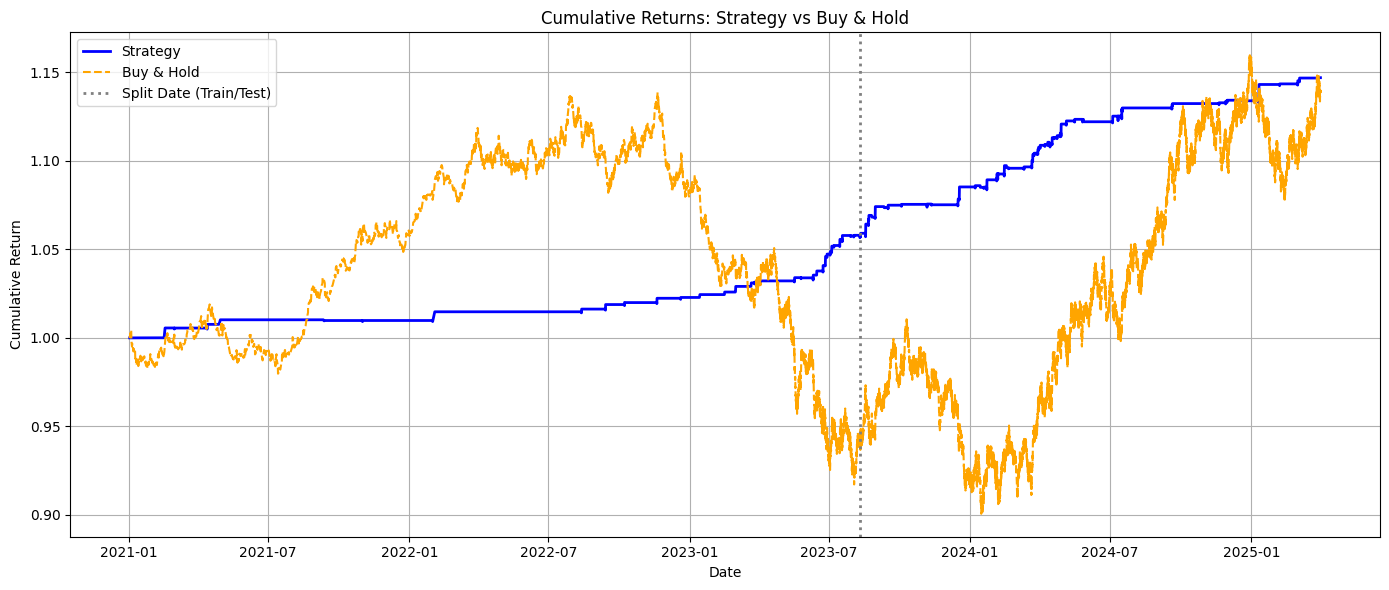

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import asyncio
from datetime import datetime, timezone
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import cybotrade_datasource

# Async query
data = await cybotrade_datasource.query_paginated(
    api_key="OiKM930Gjv61GUdBfvKgrVNaOtTjHat6dVb7DNgmINd33quN",
    topic="cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour",
    start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
    end_time=datetime(year=2025, month=4, day=1, tzinfo=timezone.utc)
)

# DataFrame setup
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['start_time'], unit='ms')
df.set_index('datetime', inplace=True)

# Feature Engineering
df['flow_mean_rolling_6h'] = df['flow_mean'].rolling(6).mean()
df['flow_mean_rolling_std'] = df['flow_mean'].rolling(6).std()
df['flow_total_rolling_6h'] = df['flow_total'].rolling(6).mean()
df['flow_mean_pct_change'] = df['flow_mean'].pct_change()
df['transactions_count_flow'] = pd.to_numeric(df['transactions_count_flow'], errors='coerce')
df['transactions_count_diff'] = df['transactions_count_flow'].diff()
df['flow_mean_zscore'] = (df['flow_mean'] - df['flow_mean'].rolling(24).mean()) / df['flow_mean'].rolling(24).std()
df.dropna(inplace=True)

# Add dummy price
np.random.seed(42)
df['price'] = 40000 + np.cumsum(np.random.randn(len(df)) * 50)

# Future return and signal generation
df['future_return'] = df['price'].shift(-6) / df['price'] - 1
df['signal'] = 0
df.loc[df['future_return'] > 0.008, 'signal'] = 1
df.loc[df['future_return'] < -0.008, 'signal'] = -1

# Clean and scale features
features = ['flow_mean_zscore', 'flow_mean_pct_change', 'flow_total_rolling_6h']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
X_clean = df[features].dropna()
df_clean = df.loc[X_clean.index].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Train-test split
split_date = '2023-08-11'
X_train = X_scaled[df_clean.index < split_date]
X_test = X_scaled[df_clean.index >= split_date]
df_train = df_clean[df_clean.index < split_date].copy()
df_test = df_clean[df_clean.index >= split_date].copy()

# HMM Model
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(X_train)

# Predict regimes
df_clean['regime'] = model.predict(X_scaled)

# Strategy mapping
df_clean['returns'] = df_clean['price'].pct_change()
regime_returns = df_clean.groupby('regime')['returns'].mean().sort_values(ascending=False)
regime_to_signal = {
    regime_returns.index[0]: 1,
    regime_returns.index[1]: 0,
    regime_returns.index[2]: -1
}
df_clean['strategy_signal'] = df_clean['regime'].map(regime_to_signal)

# Optional: Plot regimes
plt.figure(figsize=(14, 8))
plt.plot(df_clean['price'], label='Price', alpha=0.6, color='gray')
regime_colors = {0: 'green', 1: 'red', 2: 'orange'}
for regime, color in regime_colors.items():
    regime_data = df_clean[df_clean['regime'] == regime]
    plt.fill_between(regime_data.index,
                     plt.ylim()[0],
                     plt.ylim()[1],
                     where=regime_data.index.isin(df_clean.index),
                     color=color,
                     alpha=0.2,
                     label=f'Regime {regime}')
buy_signals = df_clean[df_clean['strategy_signal'] == 1]
sell_signals = df_clean[df_clean['strategy_signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['price'], marker='^', color='darkgreen', s=100, label='BUY')
plt.scatter(sell_signals.index, sell_signals['price'], marker='v', color='darkred', s=100, label='SELL')
plt.title('Price vs. HMM Regimes & Signals')
plt.legend()
plt.show()

# Strategy backtest
df['returns'] = df['price'].pct_change()
fee = 0.0006
df['strategy_returns'] = df['signal'].shift(1) * df['returns']
df['trades'] = df['signal'].diff().fillna(0).abs()
df['strategy_returns'] -= fee * df['trades']
df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
df['cumulative_buy_hold'] = (1 + df['returns']).cumprod()

# Align clean returns for backtest
df_clean[['strategy_returns', 'cumulative_strategy', 'cumulative_buy_hold']] = df[['strategy_returns', 'cumulative_strategy', 'cumulative_buy_hold']]

# Evaluation function
def evaluate_performance(df, label):
    final_pnl = df['cumulative_strategy'].iloc[-1] - 1
    annualized_sharpe = np.sqrt(6 * 365) * (df['strategy_returns'].mean() / df['strategy_returns'].std())
    peak = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - peak) / peak
    max_drawdown = drawdown.min()
    trades = (df['signal'].diff() != 0).sum()
    trade_frequency = trades / len(df) * 3

    print(f"\n📈 {label} Performance:")
    print(f"Final PnL: {final_pnl*100:.2f}%")
    print(f"Sharpe Ratio: {annualized_sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"Trade Frequency: {trade_frequency:.4f}")

# Backtest and forward test evaluation
df_backtest = df_clean[df_clean.index < split_date]
df_forward = df_clean[df_clean.index >= split_date]
evaluate_performance(df_backtest, "Backtest")
evaluate_performance(df_forward, "Forward Test")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_clean.index, df_clean['cumulative_strategy'], label='Strategy', color='blue', linewidth=2)
plt.plot(df_clean.index, df_clean['cumulative_buy_hold'], label='Buy & Hold', color='orange', linestyle='--')
plt.axvline(pd.to_datetime(split_date), color='gray', linestyle=':', linewidth=2, label='Split Date (Train/Test)')
plt.title('Cumulative Returns: Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
